In [ ]:
import pandas as pd
import os
from sqlalchemy import create_engine

# Transformers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from dotenv import load_dotenv

from pathlib import Path

# หาค่าโฟลเดอร์ปัจจุบัน
PATH = Path.cwd()

load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL")

engine = create_engine(DATABASE_URL)


In [18]:
query = """
select
    order_ts,
    delivery_time,
    distance_km,
    order_hour,
    order_dow,
    avg_rider_rating_hist,
    user_zone,
    rider_zone
from public.fct_delivery_time
where avg_rider_rating_hist is not null
order by order_ts
"""

df = pd.read_sql(query, engine)

df.sort_values("order_ts", inplace=True)

# delayed based on mean delivery time
df["is_delayed"] = (df["delivery_time"] > df["delivery_time"].mean()).astype(int)

print(f"na contain in cols :\n {df.isna().sum()}")

num_cols = ["distance_km", "order_hour", "order_dow", "avg_rider_rating_hist"]
cat_cols = ["user_zone", "rider_zone"]
target_col = "is_delayed"

na contain in cols :
 order_ts                 0
delivery_time            0
distance_km              0
order_hour               0
order_dow                0
avg_rider_rating_hist    0
user_zone                0
rider_zone               0
is_delayed               0
dtype: int64


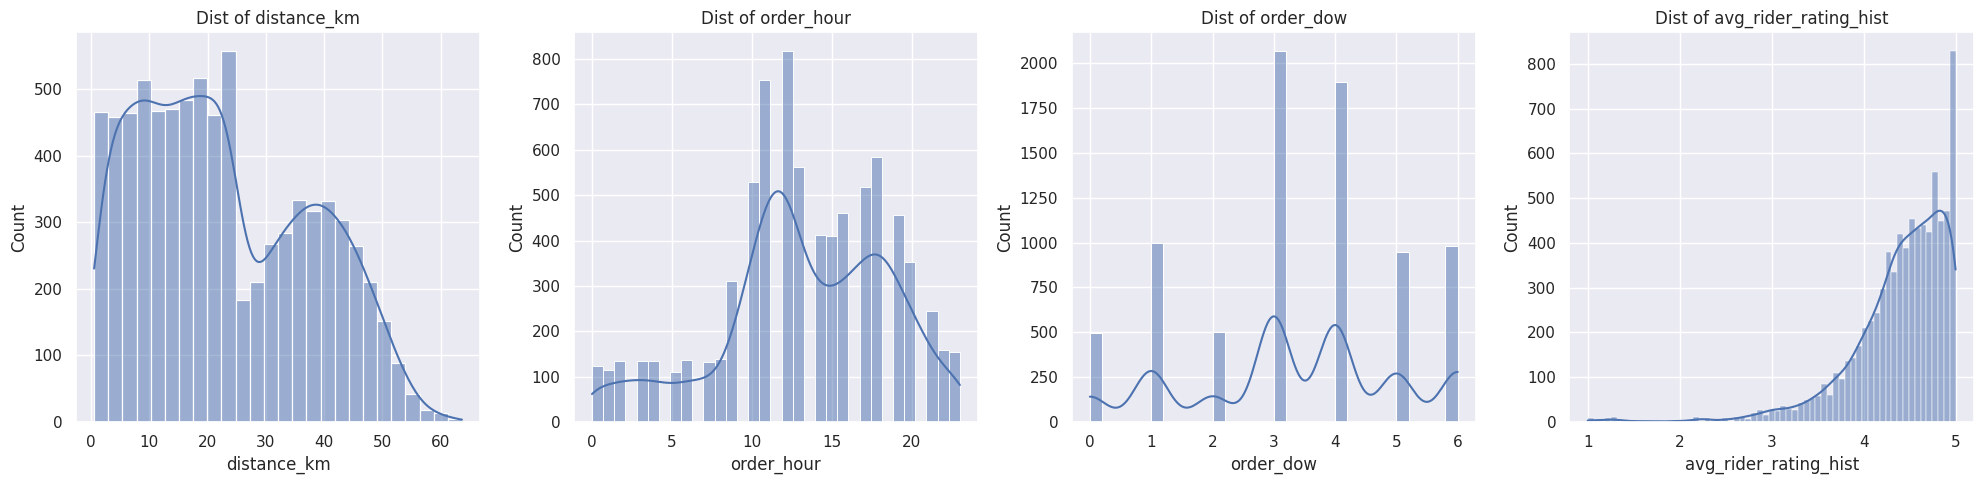

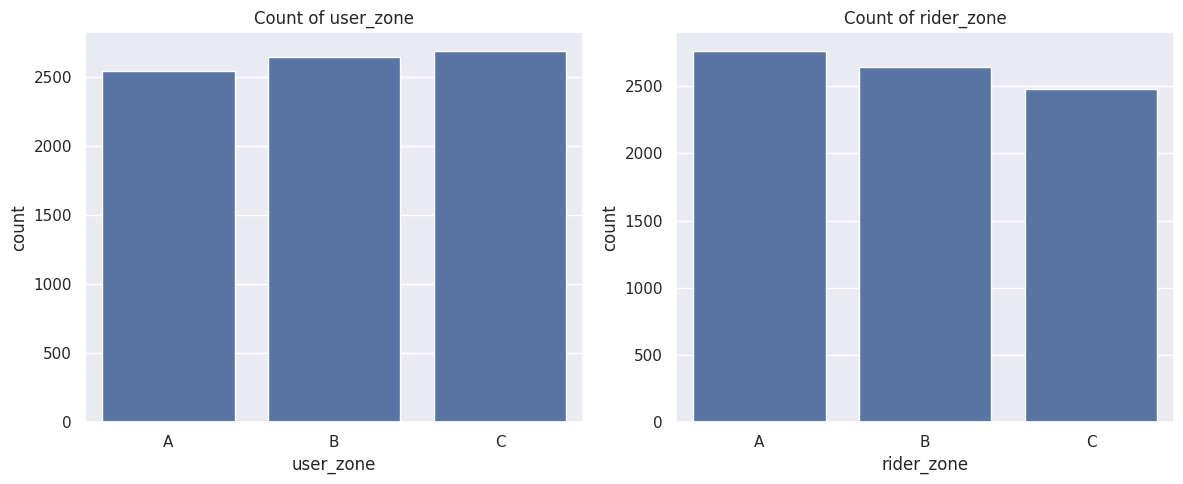

In [ ]:
#EDA visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

# num
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Dist of {col}')

plt.tight_layout()
plt.show()


# cat
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Count of {col}')

plt.tight_layout()
plt.show()

# Number cols

**distance_km** 
- have two cluster at ~15km and 40km
- guassian mixture distribution

**order_hour**
- also have two clusters at launch and dinner time
- guassian mixture distribution
**order_dow**
- is discrete where 0 is sunday 
- shouldnt use as number cols but cat instead so the model wont penalize and mis interpret the numbers

**avg_rider_rating_hist**
- severe imbalanced of data where mean is around +4 rating
- we should do log-transform


# Cat cols

**user_zone & rider_zone**
- not perfectly balanced
- where users live more in zone C while riders live more in zone A

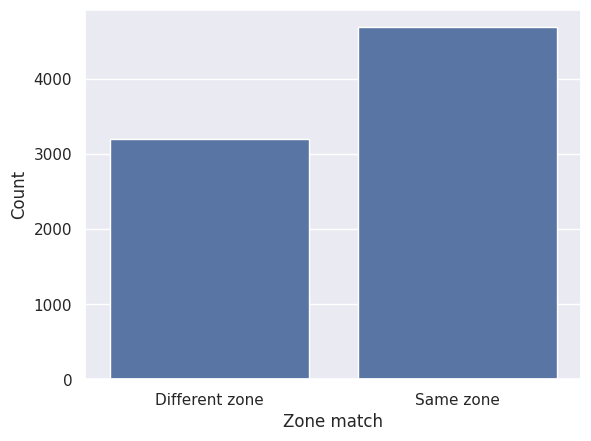

In [ ]:
#feature engineering

df["same_zone"] = (df["user_zone"] == df["rider_zone"]).astype(int)


sns.countplot(x="same_zone", data=df)
plt.xticks([0, 1], ["Different zone", "Same zone"])
plt.xlabel("Zone match")
plt.ylabel("Count")
plt.show()

In [ ]:
#move order_dow to cat_cols
num_cols = ["distance_km", "order_hour", "avg_rider_rating_hist"]
cat_cols = ["user_zone", "rider_zone", "order_dow","same_zone"]
target_col = "is_delayed"

preprocess = ColumnTransformer(
    [
        ("num", PowerTransformer(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
    ]
)

model = LogisticRegression(
    max_iter=1000, solver="saga",random_state=42
)  # saga for hypertuning regulator
scores = []

param_grid = [
    {
        "model__C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        "model__l1_ratio": [0, 0.25, 0.5, 0.75, 1],
    }
]

pipe = Pipeline([("prep", preprocess), ("model", model)])

tss = TimeSeriesSplit()

grid = GridSearchCV(pipe, param_grid, cv=tss, scoring="roc_auc",return_train_score=True)
grid.fit(df[num_cols + cat_cols], df["is_delayed"])


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...ver='saga'))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'model__C': [0.001, 0.01, ...], 'model__l1_ratio': [0, 0.25, ...]}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",TimeSeriesSpl...est_size=None)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is disp

In [17]:
cv_result = pd.DataFrame(grid.cv_results_)
cv_result.to_csv(os.path.join(PATH,"cv_result.csv"))
print(f"CV results saved to {os.path.join(PATH,'cv_result.csv')}")

print(f"Best Params: {grid.best_params_}")
print(f"Best Accuracy: {grid.best_score_:.4f}")

best_pipe = grid.best_estimator_
best_model = best_pipe.named_steps['model']
feature_names = best_pipe.named_steps['prep'].get_feature_names_out() #attr from ColumnTransformer
weights = best_model.coef_.flatten()

for name, weight in zip(feature_names, weights):
    print(f"{name:20} : {weight:.4f}")

CV results saved to /home/kheaw/projects/food-delivery-data-platform/models/delivery_time_classification/cv_result.csv
Best Params: {'model__C': 0.1, 'model__l1_ratio': 1}
Best Accuracy: 0.9611
num__distance_km     : 3.7549
num__order_hour      : 0.3428
num__order_dow       : 0.0000
num__avg_rider_rating_hist : -0.0483
cat__user_zone_B     : 0.0000
cat__user_zone_C     : 0.0000
cat__rider_zone_B    : 0.0000
cat__rider_zone_C    : -0.0199
